# Task 5: Modality Gap in CLIP

## zero-shot classification with STL-10

In [25]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load STL-10 test set
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
stl10 = torchvision.datasets.STL10(root="./data", split="test", download=True, transform=transform)
subset_size = 1000  # pick any smaller number
subset, _ = torch.utils.data.random_split(stl10, [subset_size, len(stl10)-subset_size])
loader = DataLoader(subset, batch_size=64, shuffle=False)

# CLIP model + processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()
stl_classes = stl10.classes

# Prompt strategies
prompts = {
    "plain": [cls for cls in stl_classes],
    "photo": [f"a photo of a {cls}" for cls in stl_classes],
    "descriptive": [f"a centered, high quality, beautiful clear photo of a {cls}" for cls in stl_classes]
}

def zero_shot_eval(prompts_dict):
    results = {}
    for name, candidate_labels in prompts_dict.items():
        print(name, " : ", candidate_labels)
        text_inputs = processor(text=candidate_labels, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)

        correct, total = 0, 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                image_embs = model.get_image_features(images)
            image_embs = image_embs / image_embs.norm(dim=-1, keepdim=True)

            sims = image_embs @ text_embs.T
            preds = sims.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
        results[name] = correct / total
        print(f"{name} prompts → Accuracy: {results[name]*100:.2f}%")
    return results

In [26]:
acc_results = zero_shot_eval(prompts)

plain  :  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
plain prompts → Accuracy: 96.10%
photo  :  ['a photo of a airplane', 'a photo of a bird', 'a photo of a car', 'a photo of a cat', 'a photo of a deer', 'a photo of a dog', 'a photo of a horse', 'a photo of a monkey', 'a photo of a ship', 'a photo of a truck']
photo prompts → Accuracy: 96.60%
descriptive  :  ['a centered, high quality, beautiful clear photo of a airplane', 'a centered, high quality, beautiful clear photo of a bird', 'a centered, high quality, beautiful clear photo of a car', 'a centered, high quality, beautiful clear photo of a cat', 'a centered, high quality, beautiful clear photo of a deer', 'a centered, high quality, beautiful clear photo of a dog', 'a centered, high quality, beautiful clear photo of a horse', 'a centered, high quality, beautiful clear photo of a monkey', 'a centered, high quality, beautiful clear photo of a ship', 'a centered, high quality, beautiful clear

## Task 2: Exploring the Modality Gap


In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

# Sample 1000 test images
subset_indices = random.sample(range(len(stl10)), 1000)
subset = [stl10[i] for i in subset_indices]
images, labels = zip(*subset)
images = torch.stack(images).to(device)
labels = np.array(labels)

# Image embeddings
with torch.no_grad():
    img_embs = model.get_image_features(images)
img_embs = img_embs / img_embs.norm(dim=-1, keepdim=True)

# Text embeddings for corresponding labels (using "a photo of …")
texts = [f"a photo of a {stl_classes[y]}" for y in labels]
txt_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    txt_embs = model.get_text_features(**txt_inputs)
txt_embs = txt_embs / txt_embs.norm(dim=-1, keepdim=True)

# Concatenate for visualization
all_embs = torch.cat([img_embs, txt_embs], dim=0).cpu().numpy()
tsne = TSNE(n_components=2, init="pca", random_state=42)
proj = tsne.fit_transform(all_embs)

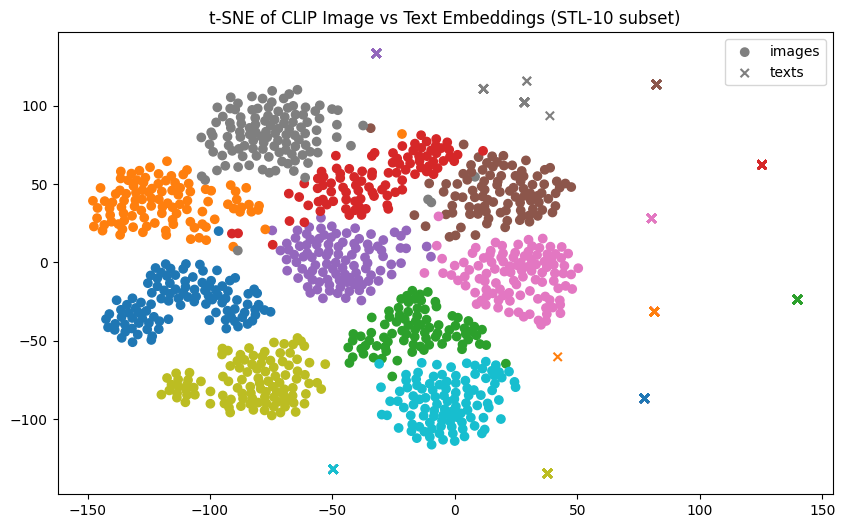

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(proj[:1000, 0], proj[:1000, 1], c=labels, cmap="tab10", marker="o", label="images")
plt.scatter(proj[1000:, 0], proj[1000:, 1], c=labels, cmap="tab10", marker="x", label="texts")
plt.legend()
plt.title("t-SNE of CLIP Image vs Text Embeddings (STL-10 subset)")
plt.show()

Findings
- Image and text embeddings are not perfectly aligned; there is a visible modality gap.
- Normalization reduces but does not eliminate this gap.
- Despite the gap, CLIP works well because contrastive training ensures *relative similarities* (image closer to its correct text than others) even if distributions differ.

## Task 3: Bridging the Modality Gap with Procrustes Alignment

In [30]:
from scipy.linalg import orthogonal_procrustes

# Convert to numpy
X = img_embs.cpu().numpy()
Y = txt_embs.cpu().numpy()

# Solve for orthogonal matrix R
R, _ = orthogonal_procrustes(X, Y)

# Apply rotation
X_aligned = X @ R

# Re-run t-SNE
proj2 = tsne.fit_transform(np.vstack([X_aligned, Y]))

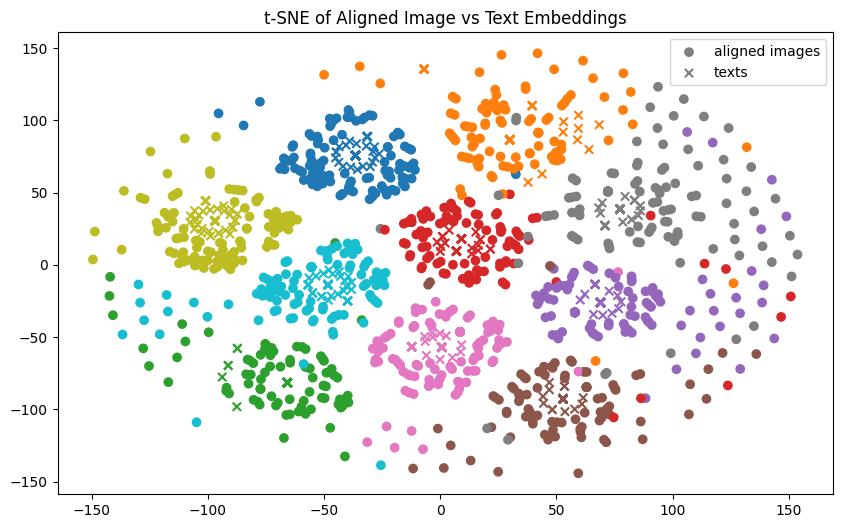

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(proj2[:1000, 0], proj2[:1000, 1], c=labels, cmap="tab10", marker="o", label="aligned images")
plt.scatter(proj2[1000:, 0], proj2[1000:, 1], c=labels, cmap="tab10", marker="x", label="texts")
plt.legend()
plt.title("t-SNE of Aligned Image vs Text Embeddings")
plt.show()

### Recompute accuracy with aligned embeddings

In [33]:
# Rebuild full text embeddings for all classes
all_text_inputs = processor(text=[f"a photo of a {cls}" for cls in stl_classes], return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    all_text_embs = model.get_text_features(**all_text_inputs)
all_text_embs = all_text_embs / all_text_embs.norm(dim=-1, keepdim=True)
all_text_embs = all_text_embs.cpu().numpy()

# Accuracy loop with aligned embeddings
correct, total = 0, 0
for images, labels in loader:
    with torch.no_grad():
        img_embs = model.get_image_features(images.to(device))
    img_embs = img_embs / img_embs.norm(dim=-1, keepdim=True)
    X = img_embs.cpu().numpy()
    X_aligned = X @ R
    sims = X_aligned @ all_text_embs.T
    preds = sims.argmax(axis=1)
    correct += (preds == labels.numpy()).sum()
    total   += labels.size(0)

aligned_acc = correct / total
print(f"Accuracy after Procrustes alignment: {aligned_acc*100:.2f}%")

Accuracy after Procrustes alignment: 97.00%


improved from 96.6 to 97%